In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union
import multiprocessing as mp
from functools import partial

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from autoencoder_keras import AutoEncoder
import resources

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = resources.config_paths()

In [3]:
# Setup Tensorflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('Num GPUs Available: ', len(gpus))
    try:
        # Limit memory usage to 5GB of the first GPU (if available)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPUs Available')

# tf.config.set_visible_devices([], 'GPU')

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [4]:
exp = 'Test 9'
exp_data = resources.load(exp)
exp_data

Test No: 9
Date: 2022-11-30
Data: ../../Testing/22_11_30_weartest_1000
No. Files: AE-158 NC4-159

In [5]:
FFT_RES = 500

# Check if exp has fft data
if FFT_RES in exp_data.ae.fft.keys():
    ffts = pd.DataFrame(exp_data.ae.fft[1000])
else:
    ffts = np.zeros((len(exp_data.ae._files), int(1e6/FFT_RES)))
    for i in range(len(exp_data.ae._files)):
        ffts[i, :] = exp_data.ae._fftcalc(i, FFT_RES)
    ffts = exp_data.ae.volt2db(np.array(ffts))
    ffts = pd.DataFrame(ffts)
ffts.drop([0, 1, 2], axis=0, inplace=True)
ffts.shape

(155, 2000)

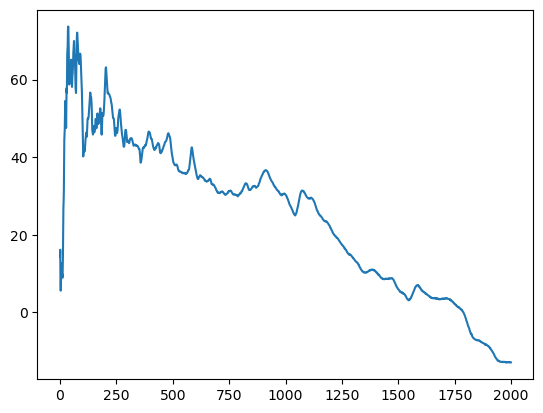

In [6]:
plt.plot(ffts.iloc[11, :])

In [7]:
def pre_process(data: np.array, ind: (tuple, tuple)):
    ind_tr, ind_val = ind

    ind_tr, ind_te = train_test_split(ind_tr,
                                      test_size=0.2,
                                      random_state=42,
                                      )
    scaler = MinMaxScaler()
    scaler.fit(data[ind_tr, :].reshape(-1, 1))
    data_sc = scaler.transform(data.reshape(-1, 1)).reshape(data.shape)

    x_train = data_sc[ind_tr, :]
    x_val = data_sc[ind_val, :]
    x_test = data_sc[ind_te, :]
    return x_train, x_test, x_val, data_sc

In [48]:
TRAIN_STOP = 50

x_train, x_test, x_val, data_sc = pre_process(ffts.values,
                                              (range(TRAIN_STOP),
                                               range(TRAIN_STOP, ffts.shape[0])
                                               ),
                                              )

In [59]:
autoe = AutoEncoder(x_train.shape[1],
                    latent_dim=16,
                    n_size=[128, 32],
                    dropout=0.1,
                    )
autoe.build_graph().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2000)]            0         
                                                                 
 encoder (Functional)        (None, 16)                260784    
                                                                 
 decoder (Functional)        (None, 2000)              262768    
                                                                 
Total params: 523,552
Trainable params: 523,552
Non-trainable params: 0
_________________________________________________________________


In [60]:
autoe.compile(optimizer=keras.optimizers.Adam(),)

In [61]:
history = autoe.fit(x_train, x_train,
                    validation_data=(x_test, x_test),
                    epochs=200,
                    batch_size=32,
                    )

Epoch 1/200


2/2 [==============================] - 0s 106ms/step - loss: 0.2343 - val_loss: 0.2210
Epoch 2/200
2/2 [==============================] - 0s 48ms/step - loss: 0.2173 - val_loss: 0.1837
Epoch 3/200
2/2 [==============================] - 0s 46ms/step - loss: 0.1774 - val_loss: 0.1300
Epoch 4/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1273 - val_loss: 0.0828
Epoch 5/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0965 - val_loss: 0.0502
Epoch 6/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0671 - val_loss: 0.0295
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0413 - val_loss: 0.0261
Epoch 8/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0326 - val_loss: 0.0208
Epoch 9/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0274 - val_loss: 0.0124
Epoch 10/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0213 - val_loss: 0.0092
Epoch 11/200
2/2 [============

Text(0.5, 0, 'Epoch')

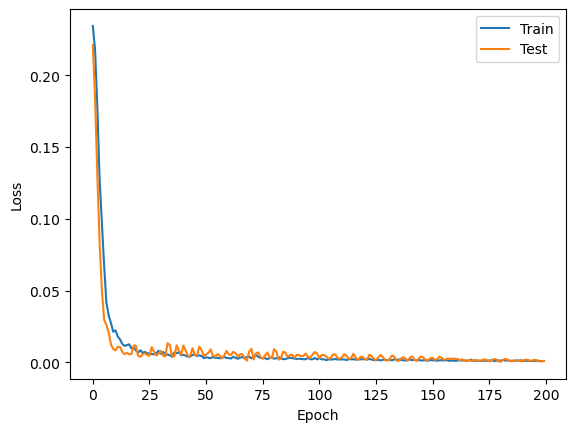

In [62]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Test')
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

In [63]:
predictions = autoe.predict(data_sc)

recon_scores = mean_squared_error(data_sc.T, predictions.T, multioutput='raw_values')

5/5 [==============================] - 0s 3ms/step


In [64]:
def pred_plot(i: Union[int, list], input, pred):
    fig, ax = plt.subplots(1, len(i), constrained_layout=True, figsize=(15, 5))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]

    for ind in range(len(i)):
        ax[ind].plot(input[i[ind], :], label='Original')
        ax[ind].plot(pred[i[ind], :], label='Reconstructed')
        ax[ind].set_ylabel('Normalised PSD')
        ax[ind].set_xlabel('Freqency Bin')
        ax[ind].set_title(f'AUTOE Reconstruction of PSD {i[ind]}')
    lines, labels = ax[0].get_legend_handles_labels()
    fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1))

    return fig, ax

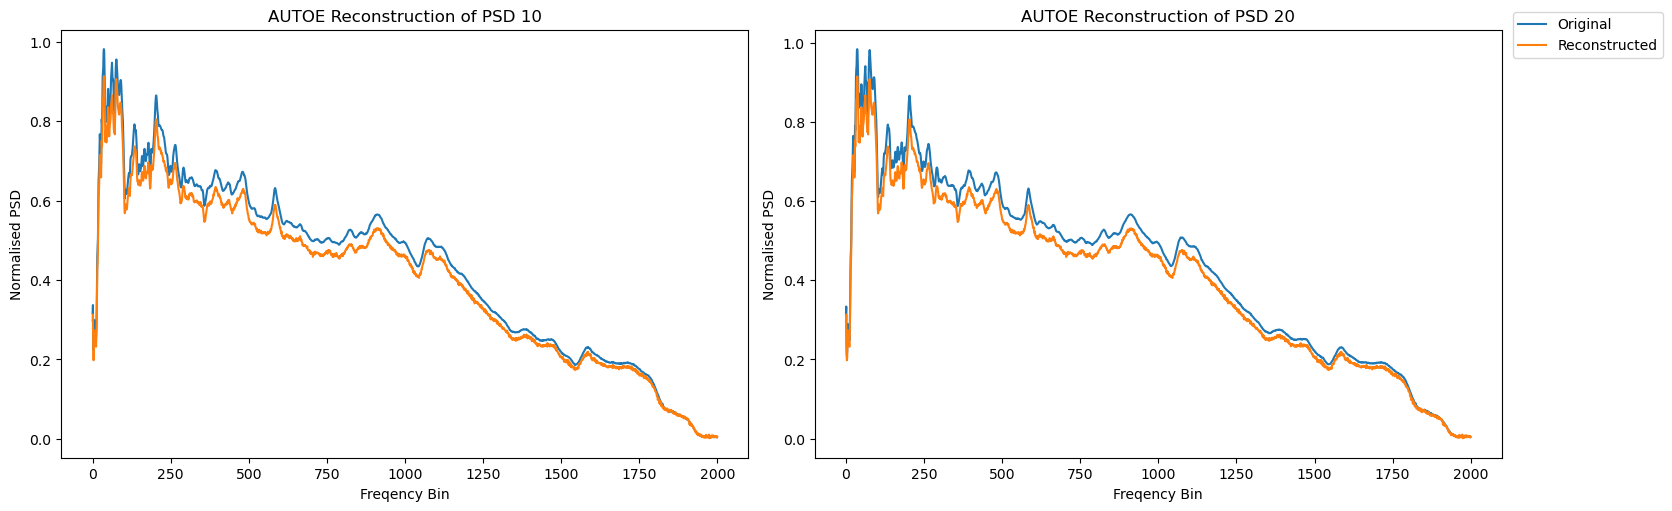

In [65]:
i = [10, 20]
pred_plot(i, data_sc, predictions)
plt.show()

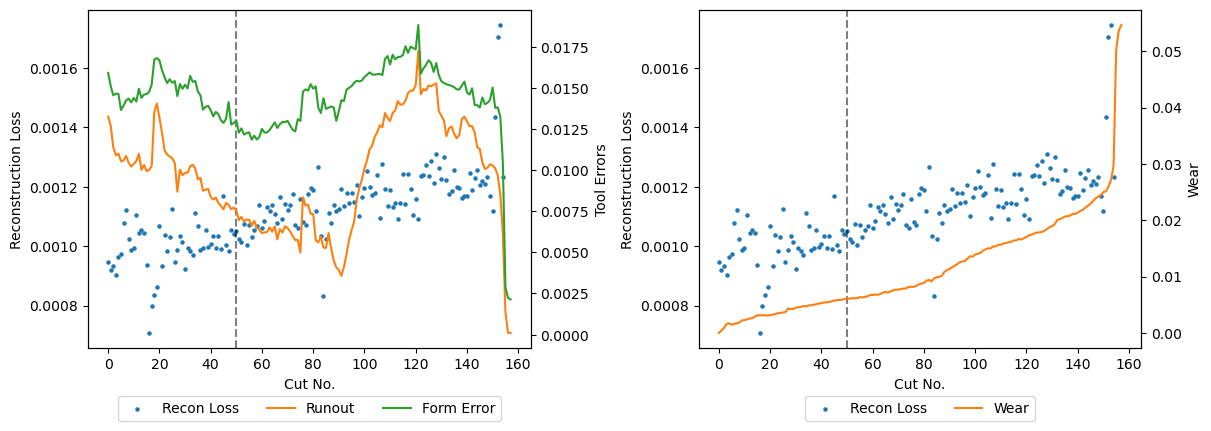

In [66]:
runout = exp_data.features['Runout']#.drop([0, 1, 2])
form_error = exp_data.features['Form error']#.drop([0, 1, 2])

fig, ax = plt.subplots(1, 2, figsize=(12, 4.2), constrained_layout=True)
ax[0].scatter(range(len(recon_scores)),
            recon_scores,
            s=5,
            label='Recon Loss',
            )
ax[0].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax[0].twinx()
ax2.plot(runout, 'C1', label='Runout')
ax2.plot(form_error, 'C2', label='Form Error')

ax[0].set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Tool Errors')
ax[0].set_xlabel('Cut No.')

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# wear plot
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad[0])

ax[1].scatter(range(len(recon_scores)),
            recon_scores,
            s=5,
            label='Recon Loss',
            )
ax[1].axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax3= ax[1].twinx()
ax3.plot(wear, 'C1', label='Wear')

ax[1].set_ylabel('Reconstruction Loss')
ax3.set_ylabel('Wear')
ax[1].set_xlabel('Cut No.')

lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax[1].legend(lines + lines2, labels + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=len(lines+lines2))

# ax[0].set_ylim(0.0004, 0.001)
# ax[1].set_ylim(0.0004, 0.001)

plt.show()

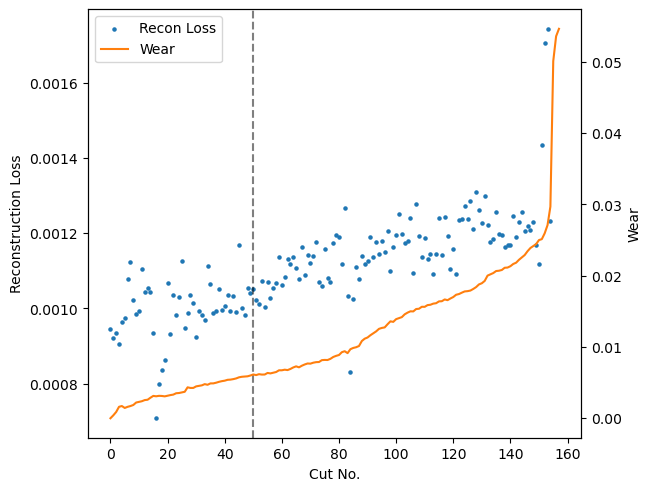

In [67]:
# wear plot
mean_rad = exp_data.features['Mean radius']
wear = np.abs(mean_rad - mean_rad[0])


fig, ax = plt.subplots(constrained_layout=True)
ax.scatter(range(len(recon_scores)),
            recon_scores,
            s=5,
            label='Recon Loss',
            )
ax.axvline(TRAIN_STOP,
            color='k',
            linestyle='--',
            alpha=0.5,
            )
ax2 = ax.twinx()
ax2.plot(wear, 'C1', label='Wear')

ax.set_ylabel('Reconstruction Loss')
ax2.set_ylabel('Wear')
ax.set_xlabel('Cut No.')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# fig.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(lines + lines2, labels + labels2, loc='best')
plt.show()

5/5 [==============================] - 0s 2ms/step


ValueError: x and y must be the same size

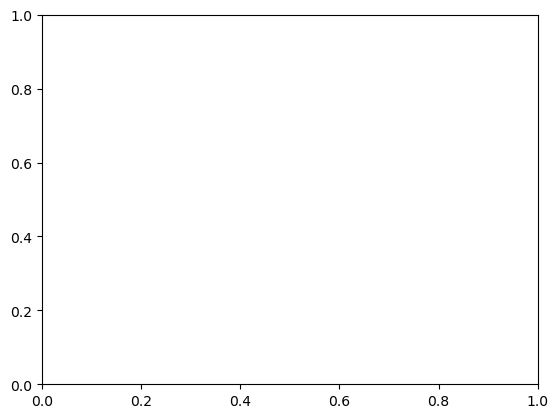

In [68]:
encoder = autoe.get_layer('encoder')
en_data = encoder.predict(data_sc)
plt.scatter(range(len(en_data)), en_data, s=5)